##Tiny NeRF
This is a simplied version of the method presented in *NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis*

[Project Website](http://www.matthewtancik.com/nerf)

[arXiv Paper](https://arxiv.org/abs/2003.08934)

[Full Code](github.com/bmild/nerf)

Components not included in the notebook
*   5D input including view directions
*   Hierarchical Sampling



In [ ]:
import os, random, datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import imageio
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import Image
from google.colab import files
%tensorflow_version 1.x
import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Load Input Images and Poses

In [ ]:
!unzip /content/rinho_noback.zip

Archive:  /content/rinho_noback.zip
   creating: rinho_noback/
  inflating: __MACOSX/._rinho_noback  
  inflating: rinho_noback/photo_2022-07-06 23.00.38.png  
  inflating: __MACOSX/rinho_noback/._photo_2022-07-06 23.00.38.png  
  inflating: rinho_noback/photo_2022-07-06 23.00.29.png  
  inflating: __MACOSX/rinho_noback/._photo_2022-07-06 23.00.29.png  
  inflating: rinho_noback/photo_2022-07-06 23.00.40(1).png  
  inflating: __MACOSX/rinho_noback/._photo_2022-07-06 23.00.40(1).png  
  inflating: rinho_noback/photo_2022-07-06 23.00.59.png  
  inflating: __MACOSX/rinho_noback/._photo_2022-07-06 23.00.59.png  
  inflating: rinho_noback/photo_2022-07-06 23.01.19.png  
  inflating: __MACOSX/rinho_noback/._photo_2022-07-06 23.01.19.png  
  inflating: rinho_noback/photo_2022-07-06 23.01.31.png  
  inflating: __MACOSX/rinho_noback/._photo_2022-07-06 23.01.31.png  
  inflating: rinho_noback/photo_2022-07-06 23.01.25.png  
  inflating: __MACOSX/rinho_noback/._photo_2022-07-06 23.01.25.png  
  i

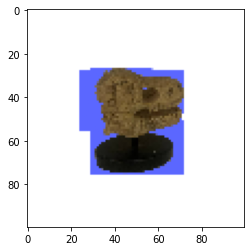

In [ ]:
def get_imgs(image_dir):
    img_names = np.array(sorted(os.listdir(image_dir)))  # all image names
    img_paths = [os.path.join(image_dir, n) for n in img_names]
    num_imgs = len(img_paths)

    img_list = []
    for p in img_paths:
      try:
        img = imageio.imread(p)[:, :, :3]  # (H, W, 3) np.uint
        img_list.append(cv2.resize(img,(100,100))) # resize if you want to minimize the computation effort. In our case we have forcely to reduce dimensions. 
      except:
        0

    img_list = np.stack(img_list)  # (N, H, W, 3)
    img_list = torch.from_numpy(img_list).float() / 255  # (N, H, W, 3) torch.float32
    H, W = img_list.shape[1], img_list.shape[2]
    
    
    return img_list, H, W, num_imgs


imgs, H, W, N_IMGS = get_imgs('rinho_noback')

# Convert from tensor to numpy
imgs = imgs.cpu().detach().numpy()
plt.imshow(imgs[0])


***Load pre-trained poses and focal lenght***

In [ ]:
poses = np.load("poses.npy")
focal = np.load('focal.npy')

focal = torch.from_numpy((focal))


#select a target
testimg, testpose = imgs[10], poses[10]


In [ ]:
focal

tensor([35.9433, 66.2561])

# Optimize NeRF

In [ ]:
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 8
embed_fn = posenc
# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)

    outputs = dense(4, act=None)(outputs)

    sigma = dense(1, act="relu")(outputs)
    # create the feature vector
    feature = dense(8)(outputs)
    # concatenate the feature vector with the direction input and put
    # it through a dense layer
    feature = tf.concat([feature, outputs], axis=-1)
    x = dense(8//2, act="relu")(feature)
    # get the rgb value
    rgb = dense(3, act="sigmoid")(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model



def rays_from_fxfy(H, W, focal, c2w):
    y, x = torch.meshgrid(torch.arange(H, dtype=torch.float32, device=focal[0].device),
                          torch.arange(W, dtype=torch.float32, device=focal[0].device))
    

    dirs_x = (x - 0.5*W) / focal[0]  # (H, W)
    dirs_y = -(y - 0.5*H) / focal[1]  # (H, W)
    dirs_z = -torch.ones(H,W,dtype=torch.float32, device=focal[0].device)

    dirs = torch.stack([dirs_x, dirs_y, dirs_z], dim=-1)

    dirs = dirs.cpu().detach().numpy()


    dirs_z = -torch.ones(H, W, dtype=torch.float32)  # (H, W)
    rays_dir = torch.stack([dirs_x, dirs_y, dirs_z], dim=-1)  # (H, W, 3)
    
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d



def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)
    
    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples) 
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3]) 
    
    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1) 
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map


Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

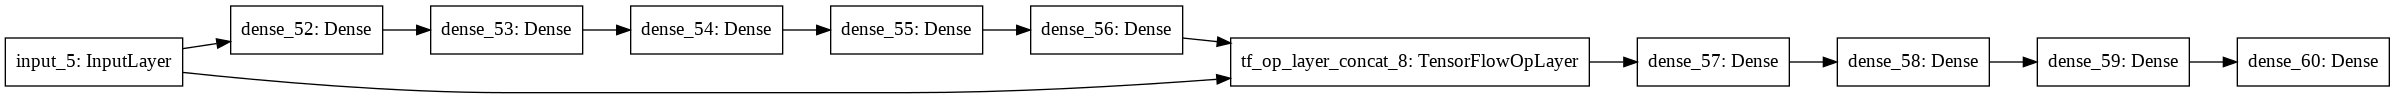

In [ ]:
from tensorflow.keras.utils import  plot_model
model = init_model()
plot_model(model, rankdir='LR')

In [ ]:
poses[52]

array([[ 0.99846435,  0.02302643,  0.05038589,  0.47404706],
       [-0.02400431,  0.99953336,  0.0188894 , -0.10872195],
       [-0.04992742, -0.02006987,  0.9985512 ,  0.05781846],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],
      dtype=float32)

0 0.012923851013183593 secs per iter


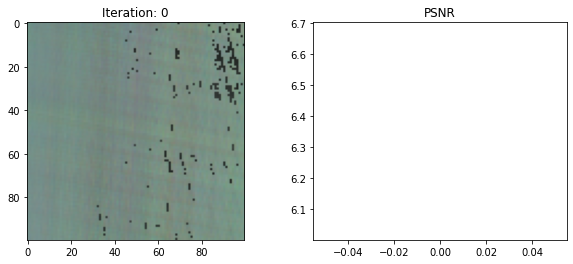

50 0.41351770401000976 secs per iter


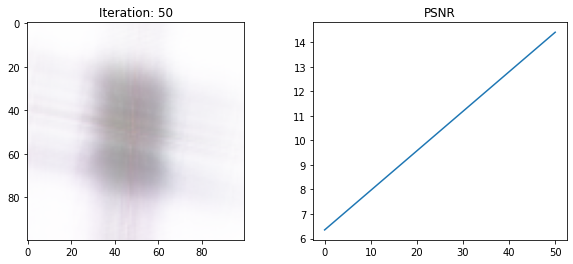

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


100 0.3878657054901123 secs per iter


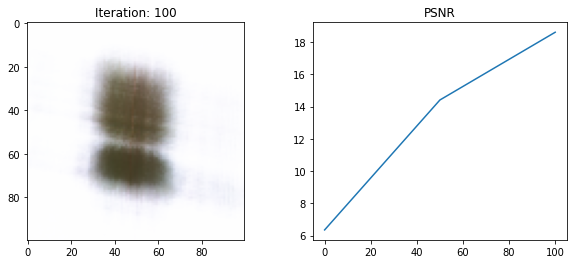

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


150 0.38755847454071046 secs per iter


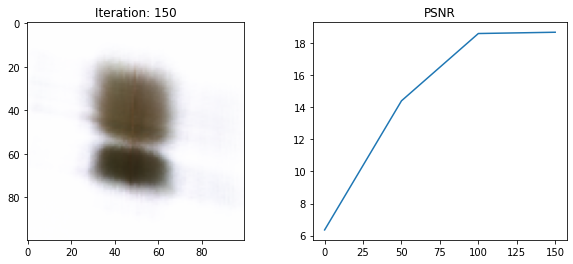

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


200 0.3869492101669312 secs per iter


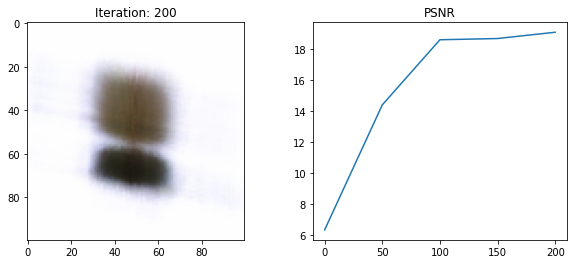

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


250 0.38705374240875245 secs per iter


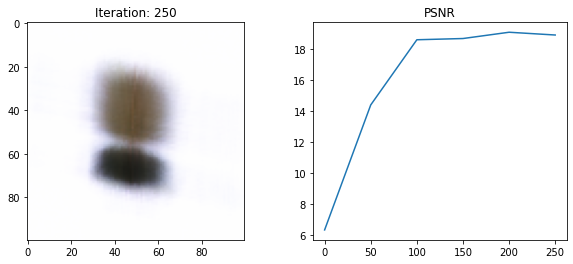

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


300 0.3922890186309814 secs per iter


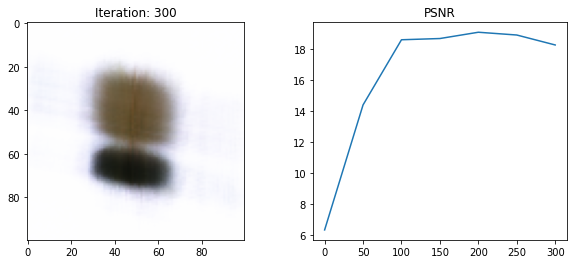

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


350 0.38711090564727785 secs per iter


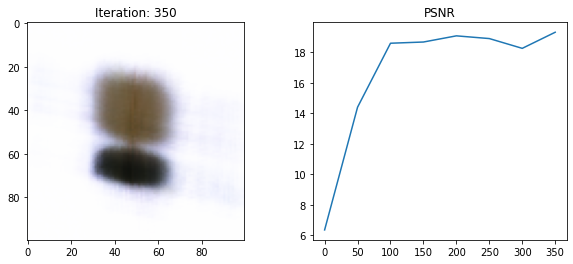

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


400 0.390597505569458 secs per iter


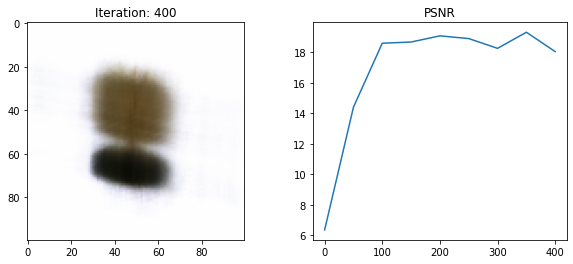

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


450 0.38709033489227296 secs per iter


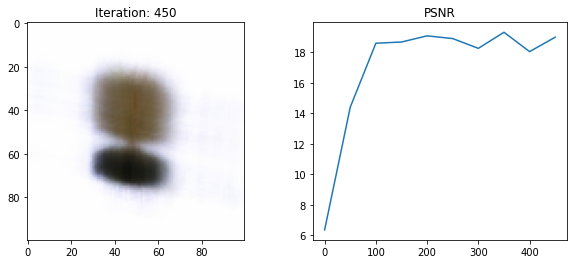

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


500 0.39657073497772216 secs per iter


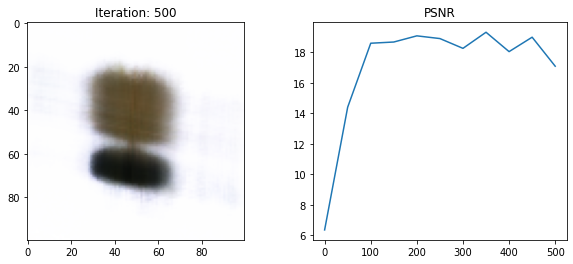

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


550 0.3872863245010376 secs per iter


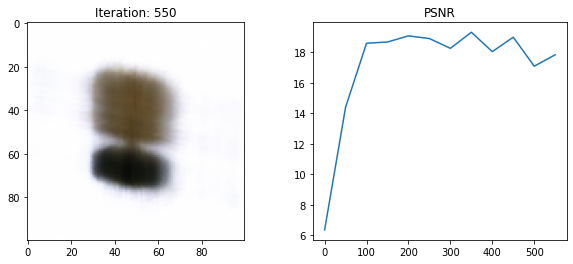

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


600 0.3873292827606201 secs per iter


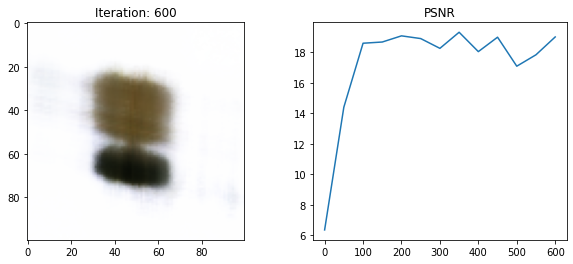

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


650 0.3875379467010498 secs per iter


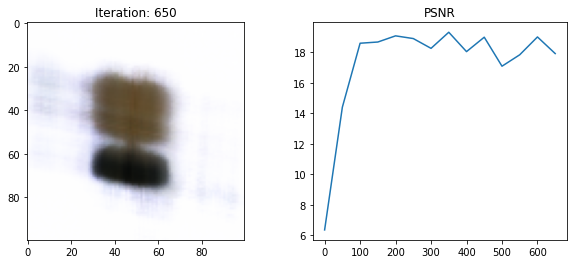

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


700 0.38795650482177735 secs per iter


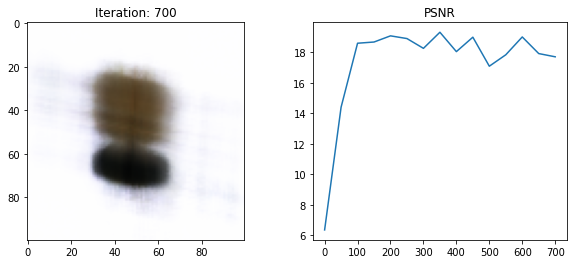

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


750 0.39062644481658937 secs per iter


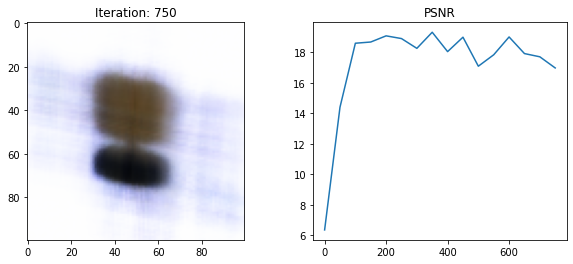

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


800 0.3873060131072998 secs per iter


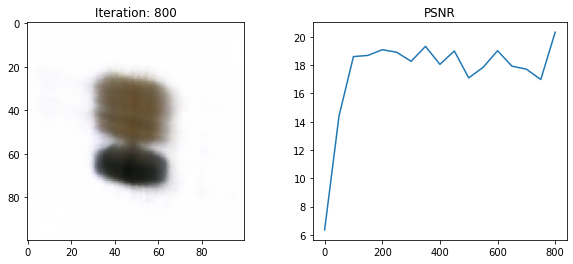

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


850 0.38698338985443115 secs per iter


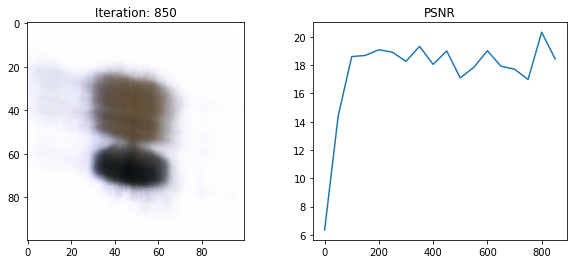

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


900 0.4118707323074341 secs per iter


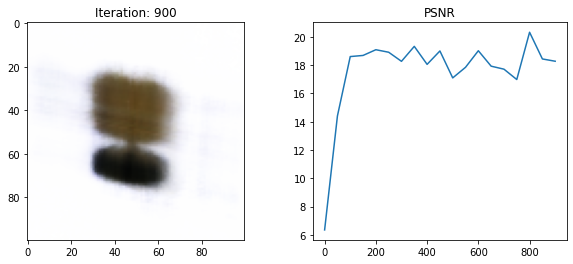

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


950 0.3875044870376587 secs per iter


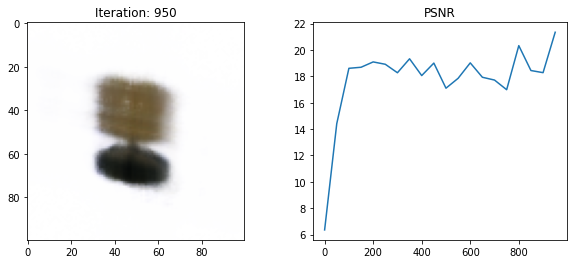

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1000 0.3870988178253174 secs per iter


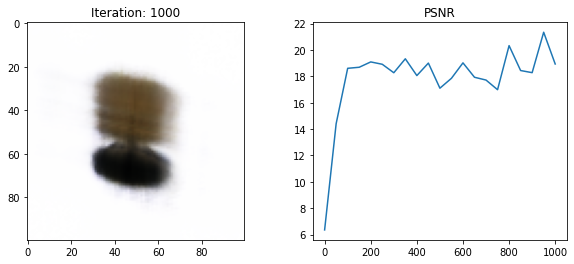

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1050 0.39051501274108885 secs per iter


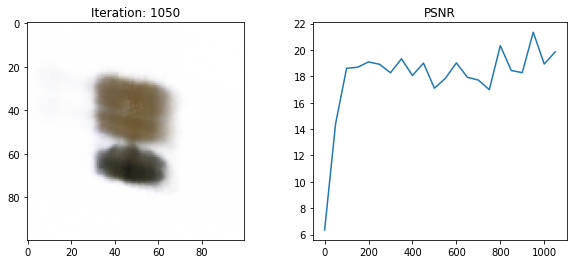

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1100 0.38676040172576903 secs per iter


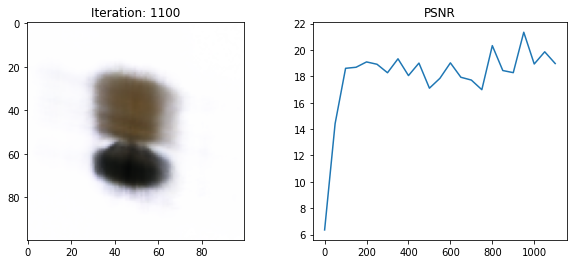

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1150 0.3932385778427124 secs per iter


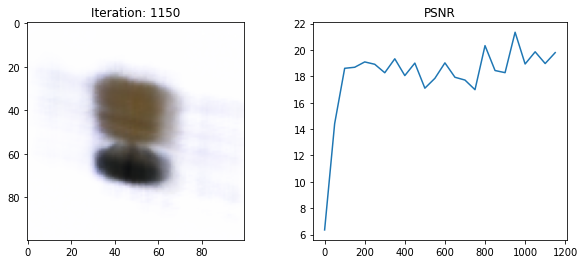

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1200 0.38796736717224123 secs per iter


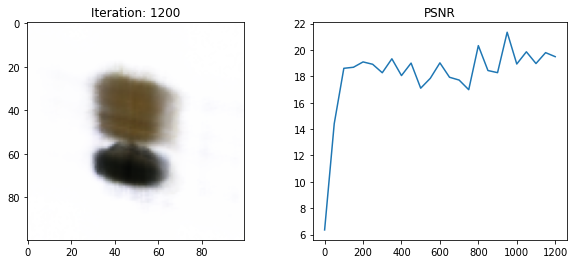

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1250 0.3879253101348877 secs per iter


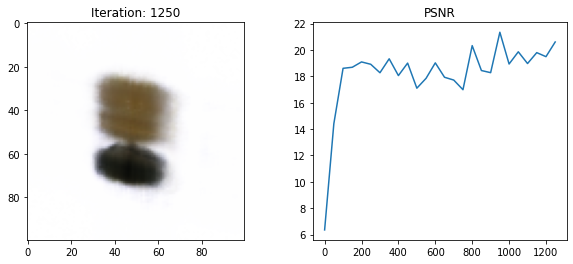

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1300 0.3896713972091675 secs per iter


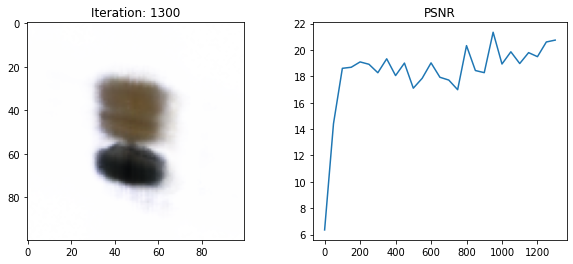

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1350 0.398380708694458 secs per iter


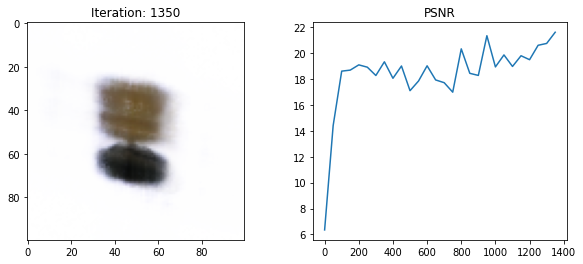

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1400 0.39241220474243166 secs per iter


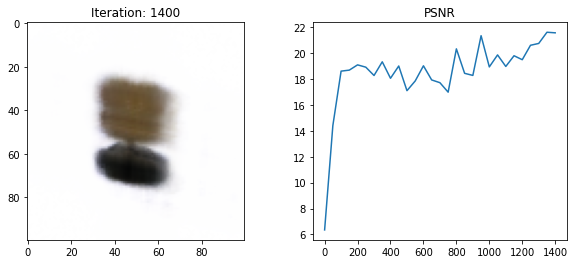

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1450 0.3886456298828125 secs per iter


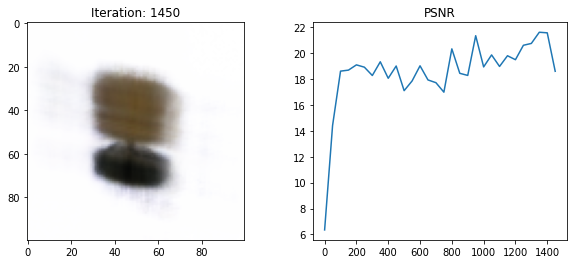

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1500 0.3884051465988159 secs per iter


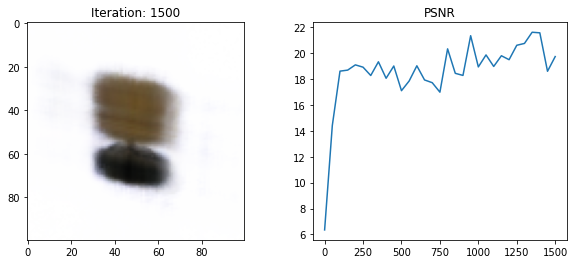

Done


In [ ]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 54
N_iters = 1500
psnrs = []
iternums = []
i_plot = 50

import time
t = time.time()
for i in range(N_iters+1):
    
    img_i = np.random.randint(52)
    target = imgs[img_i]
    pose = poses[img_i]
    rays_o, rays_d = rays_from_fxfy(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()
        
        # Render the holdout view for logging
        rays_o, rays_d = rays_from_fxfy(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)
        
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')

# Interactive Visualization

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = rays_from_fxfy(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [180., 0., 360]],
    ['phi', [-90., -90, 0]],
    ['radius', [3., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=180.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

# Render 360 Video

In [ ]:
frames = []
for rad in tqdm(np.arange(3.,5.,0.5)):
    c2w = pose_spherical(180, -90., rad)
    rays_o, rays_d = rays_from_fxfy(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=7, quality=7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
!git clone https://github.com/ActiveVisionLab/nerfmm.git

Cloning into 'nerfmm'...
remote: Enumerating objects: 94, done.
remote: Total 94 (delta 0), reused 0 (delta 0), pack-reused 94
Unpacking objects: 100% (94/94), done.


In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

NOVEL VIEW SYNTHESIS

In [ ]:
# Render novel views from a sprial camera trajectory.
# The spiral trajectory generation function is modified from https://github.com/kwea123/nerf_pl.
from nerfmm.utils.pose_utils import create_spiral_poses

# Render full images are time consuming, especially on colab so we render a smaller version instead.
resize_ratio = 4
with torch.no_grad():
    optimised_poses = torch.stack([pose_param_net(i) for i in range(N_IMGS)])
    radii = np.percentile(np.abs(optimised_poses.cpu().numpy()[:, :3, 3]), q=50, axis=0)  # (3,)
    spiral_c2ws = create_spiral_poses(radii, focus_depth=3.5, n_poses=30, n_circle=1)
    spiral_c2ws = torch.from_numpy(spiral_c2ws).float()  # (N, 3, 4)

    # change intrinsics according to resize ratio
    fxfy = focal_net()
    novel_fxfy = fxfy / resize_ratio
    novel_H, novel_W = H // resize_ratio, W // resize_ratio

    print('NeRF trained in {0:d} x {1:d} for {2:d} epochs'.format(H, W, N_EPOCH))
    print('Rendering novel views in {0:d} x {1:d}'.format(novel_H, novel_W))

    novel_img_list, novel_depth_list = [], []
    for i in tqdm(range(spiral_c2ws.shape[0]), desc='novel view rendering'):
        novel_img, novel_depth = render_novel_view(spiral_c2ws[i], novel_H, novel_W, novel_fxfy,
                                                   ray_params, nerf_model)
        novel_img_list.append(novel_img)
        novel_depth_list.append(novel_depth)

    print('Novel view rendering done. Saving to GIF images...')
    novel_img_list = (torch.stack(novel_img_list) * 255).cpu().numpy().astype(np.uint8)
    novel_depth_list = (torch.stack(novel_depth_list) * 200).cpu().numpy().astype(np.uint8)  # depth is always in 0 to 1 in NDC

    os.makedirs('nvs_results', exist_ok=True)
    imageio.mimwrite(os.path.join('nvs_results', scene_name + '_img.gif'), novel_img_list, fps=30)
    imageio.mimwrite(os.path.join('nvs_results', scene_name + '_depth.gif'), novel_depth_list, fps=30)
    print('GIF images saved.')